In [6]:
import scipy.io
import numpy as np
from numpy.fft import rfft, rfftfreq
import pandas as pd
from os import listdir, path
from os.path import isfile, join
import datetime
import dateutil.parser as parser
import matplotlib
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Signal information

In [7]:
fs = 25e3  # sampling frequency 25kHz
T = 10  # time of signal 10s
n = 999 # number of signals
N = int(fs * T)  # number of samples
dt = 1 / fs

# Prepare Data

In [8]:
def extract_all_data_from_mat(mat_path, n_signals=999):

    # Use sorted list of filenames
    only_files = sorted([file for file in listdir(mat_path) if isfile(join(mat_path, file))])
    assert len(only_files) == n_signals, 'Number of files must be equal to 999!'
    
    signal_names = []
    timestamps = []
    data = []
    
    for file_name in only_files:
            try:

                mat_file = path.join(mat_path, file_name)
                mat = scipy.io.loadmat(mat_file)
                
                # 'signal_1'
                signal_name = f'{file_name[:6]}_{int(file_name[-8:-4])}'
                
                # timestamp
                extracted_timestamp = parser.parse(mat['timestamp_str'][0])

                # numpy array containing data
                extracted_data = mat['data'][0]

            except TypeError:
                print(f'{file_name} is corrupted.')
            else:
                signal_names.append(signal_name)
                timestamps.append(extracted_timestamp)
                data.append(extracted_data)
                
    return signal_names, timestamps, np.asarray(data)

In [9]:
mat_files_path = r'C:\Users\szczy\Bachelor\MODE 7 - Miscellaneous\Data mat'

signal_names, timestamps, data = extract_all_data_from_mat(mat_files_path)

In [10]:
# Change last timestamp
penultimate_timestamp = timestamps[-2]

timestamps[-1] = datetime.datetime(
    penultimate_timestamp.year, 
    penultimate_timestamp.month,
    penultimate_timestamp.day + 1,
    penultimate_timestamp.hour,
    penultimate_timestamp.minute,
    penultimate_timestamp.second)

# RMS

In [11]:
def root_mean_square(data):
    return np.sqrt(np.mean(np.square(data), axis=1))

In [12]:
mode7_rms = root_mean_square(data)

# Magnitude Spectrum

In [13]:
def magnitude_spectrum(signal):
    return np.abs(rfft(signal)) / (len(signal) / 2)

# Spectrum Averaging

In [14]:
def spectrum_averaging(signal, k):
    return np.mean(
        a=[magnitude_spectrum(signal_fragment) for signal_fragment in np.split(signal, k)],
        axis=0)

In [15]:
def plot_averaged_spectrums(averaged_spectrum, freq, k=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    label='No averaging'
    if k:
        label = f'k = {k}'
        if k > 1000:
            ax[0].stem(freq, averaged_spectrum[0], 'r', markerfmt='None')
            ax[1].stem(freq, averaged_spectrum[-1], 'r', markerfmt='None')
            
    ax[0].plot(freq, averaged_spectrum[0], label=label)
    ax[0].set_title('Averaged Spectrum for Signal 1')
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Amplitude[-]')
    ax[0].legend(loc='upper right')
    
    ax[1].plot(freq, averaged_spectrum[-1], label=label)
    ax[1].set_title('Averaged Spectrum for Signal 999')   
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('Amplitude[-]')
    ax[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    No averaging, M = 125,001 frequency components

In [16]:
mode7_spectrum = np.vstack([magnitude_spectrum(signal) for signal in data])
freq = rfftfreq(N, dt)

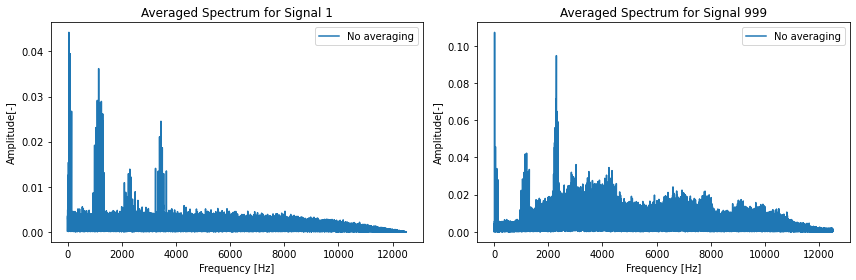

In [17]:
plot_averaged_spectrums(mode7_spectrum, freq)

    k = 100, M = 1251 frequency components

In [18]:
k = 100
mode7_spectrum_1e2 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_1e2 = rfftfreq(int(N / k), dt)

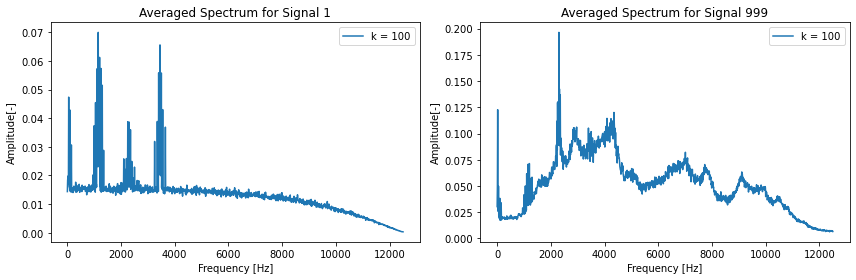

In [19]:
plot_averaged_spectrums(mode7_spectrum_1e2, freq_1e2, k=100)

    k = 1,000, M = 126 frequency components

In [20]:
k = 1e3
mode7_spectrum_1e3 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_1e3 = rfftfreq(int(N / k), dt)

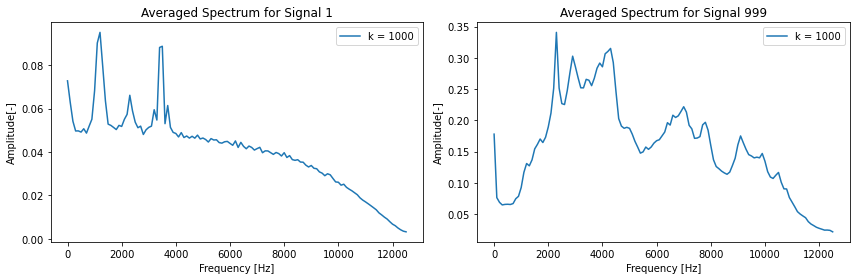

In [21]:
plot_averaged_spectrums(mode7_spectrum_1e3, freq_1e3, k=1000)

    k = 2,500, M = 51 frequency components

In [22]:
k = 25e2
mode7_spectrum_25e2 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_25e2 = rfftfreq(int(N / k), dt)

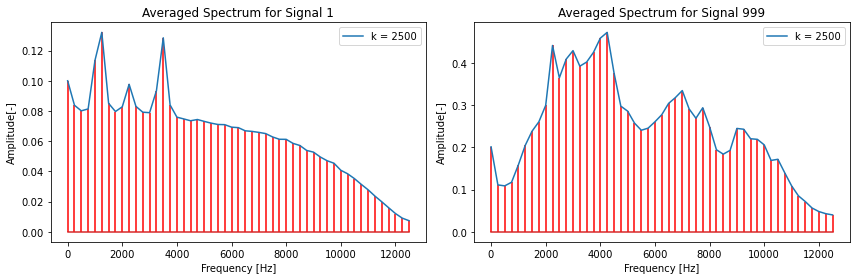

In [23]:
plot_averaged_spectrums(mode7_spectrum_25e2, freq_25e2, k=2500)

    k = 25,000, M = 6 frequency components

In [24]:
k = 25e3
mode7_spectrum_25e3 = np.vstack([spectrum_averaging(signal, k) for signal in data])
freq_25e3 = rfftfreq(int(N / k), dt)

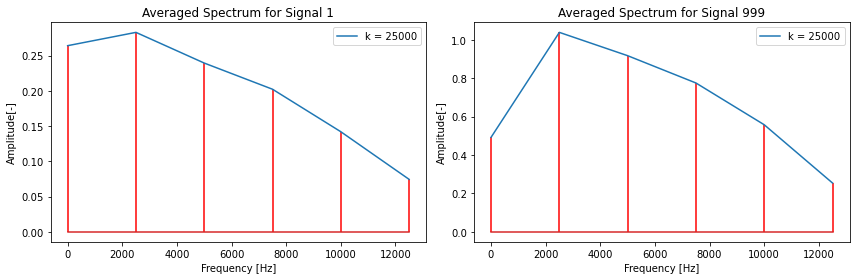

In [25]:
plot_averaged_spectrums(mode7_spectrum_25e3, freq_25e3, k=25000)

# Create dataset containing data from Averaged Spectrum

In [624]:
X_dict = {timestamps[j]: {f'{freq_25e3[i].astype(int)} Hz': val for i, val in enumerate(mode7_spectrum_25e3[j])} for j in range(n)}

X = pd.DataFrame.from_dict(X_dict, orient='index')
X.head()

,0 Hz,2500 Hz,5000 Hz,7500 Hz,10000 Hz,12500 Hz
2020-10-16 10:51:26,0.264139,0.283021,0.239476,0.202321,0.142027,0.074450
2020-10-17 10:51:26,0.265198,0.281232,0.237027,0.201191,0.142331,0.075949
2020-10-18 10:51:26,0.267648,0.283040,0.238770,0.202629,0.141635,0.074828
2020-10-19 10:51:26,0.270472,0.303628,0.258640,0.217723,0.154240,0.079855
2020-10-20 10:51:26,0.271195,0.281651,0.238852,0.201146,0.142021,0.075331


In [625]:
X.describe()

,0 Hz,2500 Hz,5000 Hz,7500 Hz,10000 Hz,12500 Hz
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.304482,0.435825,0.390045,0.328883,0.234795,0.114133
std,0.034080,0.123231,0.120565,0.101166,0.073773,0.031872
min,0.261267,0.278181,0.235607,0.199765,0.140216,0.073684
25%,0.274772,0.325561,0.282196,0.238386,0.169061,0.085650
50%,0.296750,0.416337,0.372722,0.313798,0.224141,0.109196
75%,0.327872,0.525506,0.478821,0.402658,0.289336,0.137376
max,0.492479,1.039268,0.917763,0.775560,0.557848,0.254285


## Distribution of our data

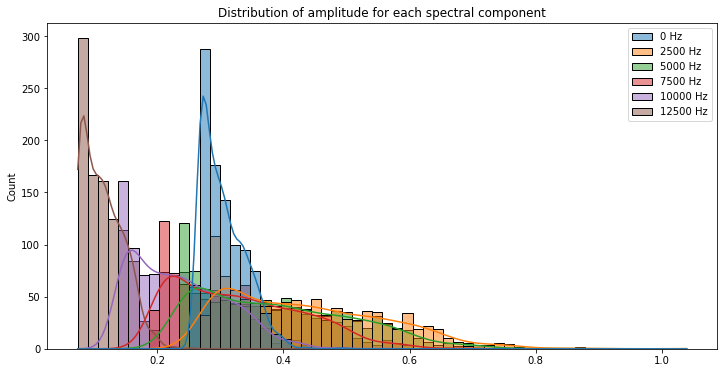

In [626]:
plt.figure(figsize=(12, 6))
plt.title('Distribution of amplitude for each spectral component')
sns.histplot(X, bins=60, kde=True)
plt.show()

In [627]:
for col in X:
    print(f'Skewness of {col} is {X[col].skew()}')
    print(f'Kurtosis of {col} is {X[col].kurt()}\n')

Skewness of 0 Hz is 0.9643584166404577
Kurtosis of 0 Hz is 0.8126262498678121

Skewness of 2500 Hz is 0.7110116097515473
Kurtosis of 2500 Hz is 0.11083783067039121

Skewness of 5000 Hz is 0.6608149994007297
Kurtosis of 5000 Hz is -0.11854263413246846

Skewness of 7500 Hz is 0.6688181818707286
Kurtosis of 7500 Hz is -0.09008533877097724

Skewness of 10000 Hz is 0.6558199952820609
Kurtosis of 10000 Hz is -0.1274703962057644

Skewness of 12500 Hz is 0.6897432677532169
Kurtosis of 12500 Hz is -0.06058457707839793



Data for none of the spectral component is normally distributed. They are all skewed towards left, meaning that the anomalies are present, however their occurence is rare and appears more frequently as the time passes.

For the purpose of finding the threshold using statistical approach, I will use the Median Absolute Deviance (MAD), since finding the outliers using the Standard Deviation is valid only for normally distributed dataset.

## Correlation matrix for all spectral components

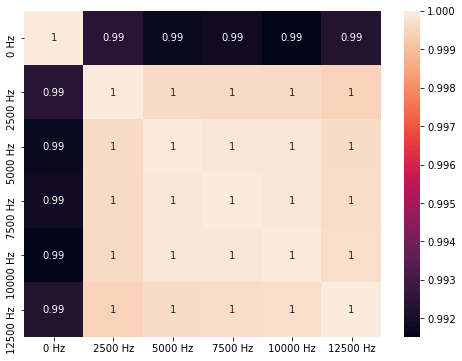

In [628]:
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

From the correlation matrix we can see, that each spectral component is highly dependend on all other components.

**Since there is almost 100% correlation between each separate frequency component, reducing the dimentions while mainaining k-value high, will significantly decrease the accuracy.**

> However, because of very large amount of data and knowing that each spectral component has almost uniform impact on spectral magnitude at other frequencies, we can use the DC as the feature and fs/2 as target, or only these 2 frequency components as features.

## Scale the dataset
We know that the dataset is not normally distributed. 
That's why the MinMaxScaler is used, in order to have the outliers' values spread closer to 1, and safe samples closer to 0. 

In [629]:
from sklearn.preprocessing import MinMaxScaler

As mentioned above, the correlation of all features is almost the same and exceeds 99%. That's why all samples are scaled.

In [630]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# Anomaly Detection - Statistical Approach

In [689]:
# 1. Calculate the median of amplitudes for each spectral component
median_6f = X.median(axis=0) 

# 2. Calculate the deviation from the median, using the absolute value of the deviations, |x — median(population)|= deviation
deviation_6f = np.abs(X - median_6f) 


### Table presenting amplitudes for each spectral component

In [632]:
X.head()

,0 Hz,2500 Hz,5000 Hz,7500 Hz,10000 Hz,12500 Hz
2020-10-16 10:51:26,0.264139,0.283021,0.239476,0.202321,0.142027,0.074450
2020-10-17 10:51:26,0.265198,0.281232,0.237027,0.201191,0.142331,0.075949
2020-10-18 10:51:26,0.267648,0.283040,0.238770,0.202629,0.141635,0.074828
2020-10-19 10:51:26,0.270472,0.303628,0.258640,0.217723,0.154240,0.079855
2020-10-20 10:51:26,0.271195,0.281651,0.238852,0.201146,0.142021,0.075331


### Table presenting median for each spectral component

In [633]:
median_6f.head()

0 Hz        0.296750
2500 Hz     0.416337
5000 Hz     0.372722
7500 Hz     0.313798
10000 Hz    0.224141
dtype: float64

### Table presenting deviation from median for each spectral component

In [634]:
deviation_6f.head()

,0 Hz,2500 Hz,5000 Hz,7500 Hz,10000 Hz,12500 Hz
2020-10-16 10:51:26,0.032611,0.133315,0.133245,0.111477,0.082114,0.034747
2020-10-17 10:51:26,0.031551,0.135104,0.135695,0.112606,0.081809,0.033248
2020-10-18 10:51:26,0.029101,0.133296,0.133951,0.111169,0.082505,0.034369
2020-10-19 10:51:26,0.026278,0.112709,0.114081,0.096075,0.069901,0.029341
2020-10-20 10:51:26,0.025555,0.134685,0.133869,0.112652,0.082120,0.033865


In [635]:
# 3. Find the median of the absolute deviations, median(|deviations|), called scaling factor
mad_6f = np.median(np.abs(deviation_6f), axis=0)

# 4. Add the scaling factor to the median of the population for the upper bound
upper_bound_6f = median_6f.values + (3 * mad_6f)

# 5. Subtract the scaling factor from the median of the population for the lower bound
lower_bound_6f = median_6f.values - (3 * mad_6f)

# 6. Anything outside of the bounds is an outlier

In [690]:
# Median as threshold
median_anomalies = pd.DataFrame()
median_dates = []
for i, col in enumerate(X.columns):
    median_anomalies[col] = X[col].loc[X[col] > median_6f[i]]
    for idx, row in median_anomalies[col].items():
        if row != None:
            median_dates.append(idx)
            break

median_date_threshold = min(median_dates)

### Timestamp of anomaly's first occurence for each spectral component

In [637]:
anomalies = pd.DataFrame()
anomaly_dates = []

for i, col in enumerate(X.columns):
    anomalies[col] = X[col].loc[X[col] > upper_bound_6f[i]]
    for idx, row in anomalies[col].items():
        if row != None:
            anomaly_dates.append(idx)
            break
            
statistical_date_threshold = min(anomaly_dates)
print('Potential date before defect development for whole signal:', statistical_date_threshold)

Potential date before defect development for whole signal: 2022-10-19 10:51:26


## Outliers fraction

In [638]:
n_outliers = [anomalies[col].count() for col in anomalies.columns]
outliers_fraction = max(n_outliers) / len(X) # in %

print('The outliers fraction is {:.2f}%'.format(outliers_fraction * 100))

The outliers fraction is 4.10%


### Function for plotting anomalies

In [639]:
def plot_anomalies(X, anomalies, lower_bound, upper_bound, anomaly_dates, title, limit=False):    
    
    n_cols = 2
    if limit:  
        n_rows = 1
        fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * (n_cols + 1), 6 * n_rows))
    else:
        n_rows = 3
        fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * (n_cols + 1), 6 * n_rows))
        n_anomalies = [anomalies[col].count() for col in anomalies.columns]

    c_id = 0
    for i in range(n_rows):
        for j in range(n_cols):       
            n_outliers = len(anomalies)
            if limit:
                new_ax = ax[j]
                if c_id > 0:
                    c_id = - 1
            else:
                new_ax = ax[i, j]
                n_outliers = n_anomalies[c_id]
                
            new_ax.plot(X.index, X.iloc[:, c_id], label=f'{X.columns[c_id]}', zorder=0)
            new_ax.scatter(anomalies.index, anomalies.iloc[:, c_id], label=f'Anomalies: {n_outliers}', color='red', edgecolor='k', zorder=2)

            new_ax.fill_between(x=timestamps, y1=lower_bound[c_id], y2=upper_bound[c_id], 
                                  color='green', 
                                  alpha=0.25,
                                  zorder=-1,
                                  label='Normal amplitude range [-3σ, +3σ]')

            new_ax.fill_between(x=timestamps, y1=upper_bound[c_id], y2=X.iloc[:, c_id].max() * 1.1, 
                                  color='red', 
                                  alpha=0.25,
                                  zorder=-1,
                                  label='Anomaly amplitude range [exceeds ±3σ]')
            
            if isinstance(anomaly_dates, list):
                date_threshold = anomaly_dates[c_id]
            else:
                date_threshold = anomaly_dates
            
            new_ax.vlines(
                x=date_threshold, 
                ymin=0.9 * X.iloc[:, c_id].min(),
                ymax=0.9 * X.iloc[:, c_id].max(),
                linestyles='dashed',
                colors='k', 
                zorder=1,
                label=f"Potential date before failure progression: {date_threshold.strftime('%Y-%m-%d')}"
            )

              
            new_ax.set_xlabel('Time')
            new_ax.set_ylabel('Amplitude')
            new_ax.legend(loc='upper left')
            
            for tick in new_ax.get_xticklabels():
                tick.set_rotation(45)
            
            if c_id == -1: 
                break
            else:
                c_id += 1

    fig.suptitle(f'{title} approach - anomalies for different spectral components')
    plt.tight_layout()
    
    title = '_'.join(title.split())
    plt.savefig(f'images/{title}_6f.png')
    plt.show()

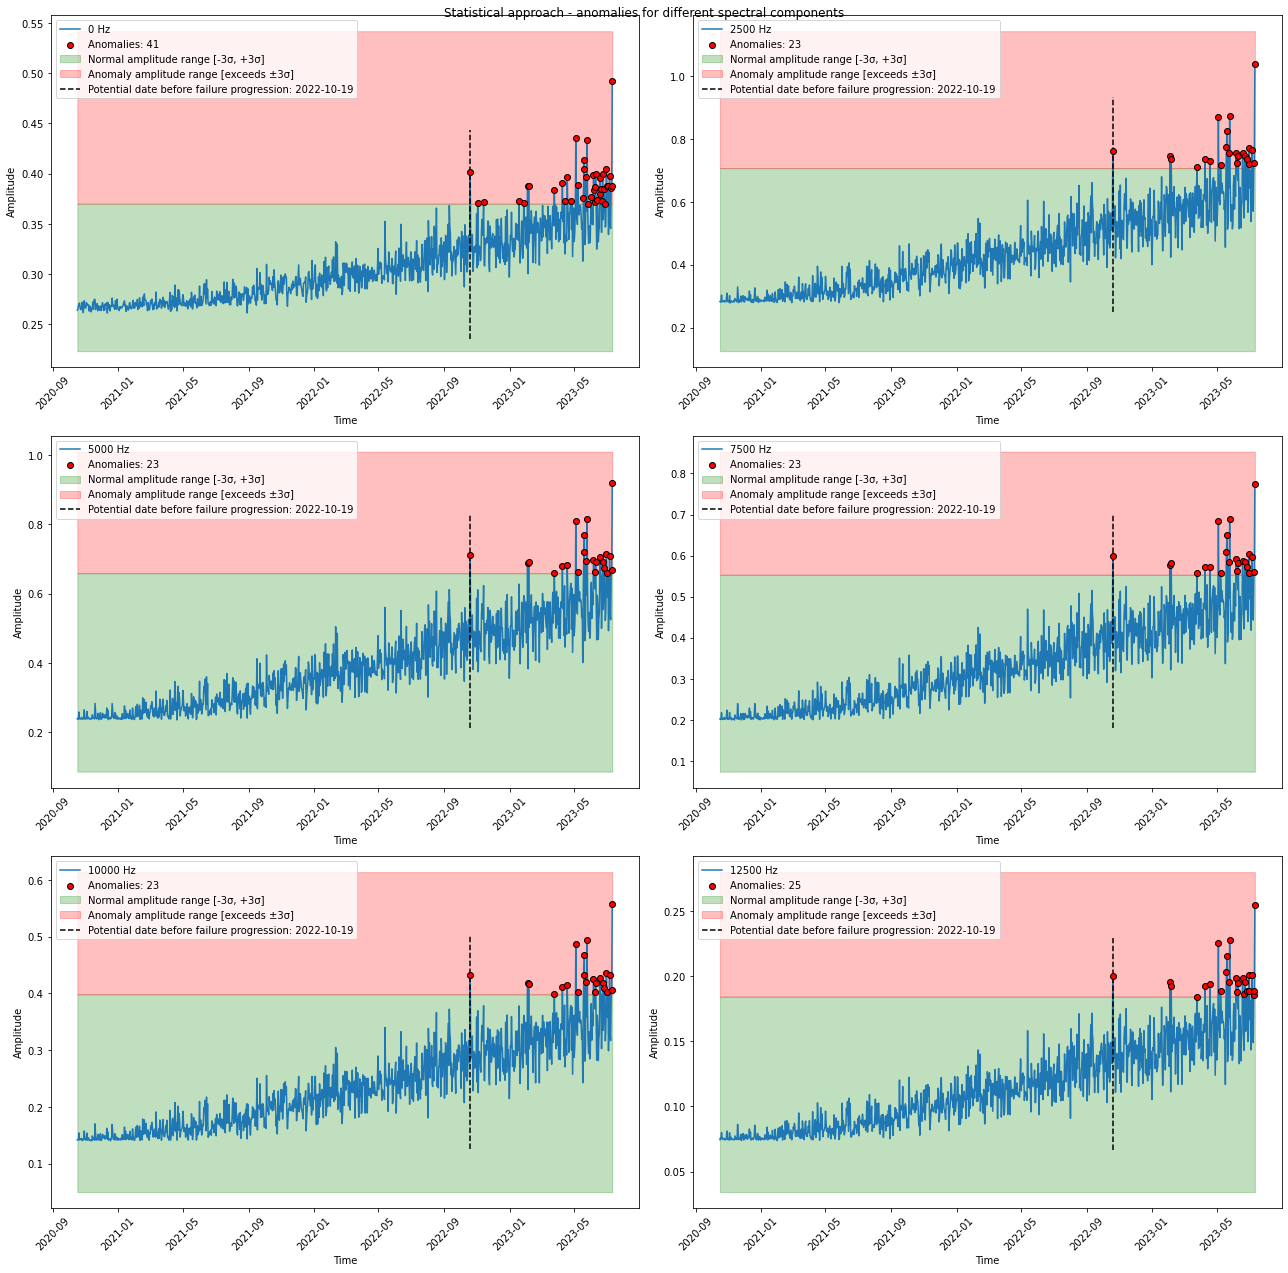

In [640]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, anomaly_dates, title='Statistical', limit=False)

## Anomalies within spectral components


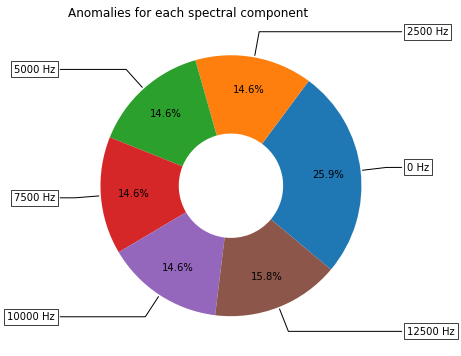

In [641]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"), facecolor='w')

wedges, texts, autotexts = ax.pie(
    n_outliers, 
    autopct='%1.1f%%',
    pctdistance=0.75,
    wedgeprops=dict(width=0.6), 
    startangle=-40)

bbox_props = dict(
    boxstyle="square, pad=0.3", 
    fc="w", 
    ec="k", 
    lw=0.74)

kw = dict(
    arrowprops=dict(arrowstyle="-"),
    bbox=bbox_props, 
    zorder=0, 
    va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {(-1): "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle, angleA=0, angleB = {}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        X.columns[i], 
        xy=(x, y), 
        xytext=(1.35 * np.sign(x), 1.2 * y),
        horizontalalignment=horizontalalignment, 
        **kw)

ax.set_title('Anomalies for each spectral component', loc='left')
plt.savefig('images/anomaly_donut.png')
plt.show()

## Statistical Approach - Conclusion
For all spectral components, development of the defect is visible from 19th October 2022.
Moreover we can observe, that all of the spectral components except DC and fs/2 have same number of anomalies - at 0 Hz 25.9% of anomalies occur, while on 12500 Hz occurs only 1.2% more anomalies than on frequencies higher than DC.
It is a very important conclusion, since we may reduce the number of features in our training set to 2 - DC and fs/2.

# Multivariate Unsupervised Learning
Here I take all of the spectral components as features, and search for the date, on which the whole amplitude spectrum begins to give the user signs, that the failure development may have started.

In [642]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

## KMeans

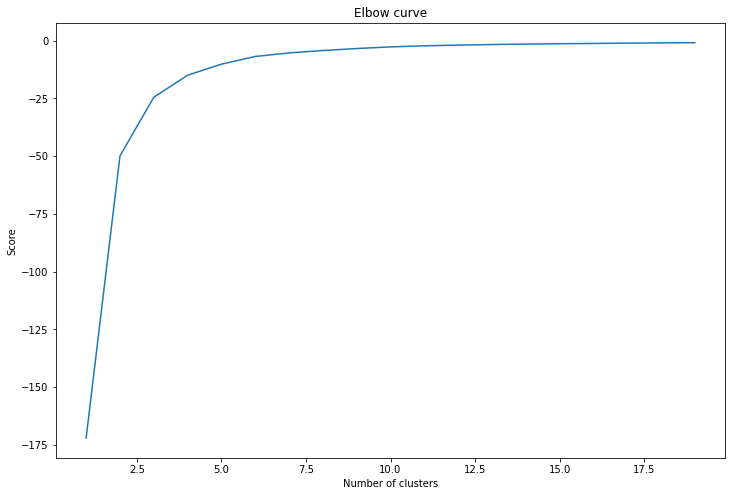

In [643]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_clusters = range(1, 20)
kmeans_arr = [KMeans(n_clusters=i).fit(X_scaled) for i in n_clusters]
scores_arr = [kmeans_arr[i].score(X_scaled) for i in range(len(kmeans_arr))]

plt.figure(figsize=(12, 8))
plt.plot(n_clusters, scores_arr)
plt.xlabel('Number of clusters'), plt.ylabel('Score')
plt.title('Elbow curve')
plt.show()

Based on the elbow curve, we see that the graph starts to flatten after 10 clusters, thus applying higher number of clusters will not explain the variance.

In [644]:
n_clusters = 10

In [645]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
def get_distance_from_point(data, model):
    distance_series = pd.Series(dtype=np.float64)
    for i in range(len(data)):
        Xa = np.array(data[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        distance_series.at[i] = np.linalg.norm(Xa - Xb)
    return distance_series

In [646]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
kmeans_model = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_model.fit(X_scaled)

distance_series = get_distance_from_point(X_scaled, kmeans_model)
number_of_outliers = int(outliers_fraction * len(distance_series)) # max(n_outliers)

threshold = distance_series.nlargest(number_of_outliers).min() # nlargest returns the largest n elements, min will return the first anomaly and we will use it as a threshold

anomalies = X.copy()
anomalies['Anomaly'] = [1 if distance > threshold else 0 for distance in distance_series] # 0: normal, 1: anomaly
anomalies['Anomaly'].value_counts()

0    959
1     40
Name: Anomaly, dtype: int64

In [647]:
anomalies = anomalies.loc[anomalies['Anomaly'] == 1].drop(columns='Anomaly', inplace=False)

kmeans_date_threshold = anomalies.index[0] # first date that is labeled as anomaly
print('Potential date before defect development:', kmeans_date_threshold)

Potential date before defect development: 2022-04-30 10:51:26


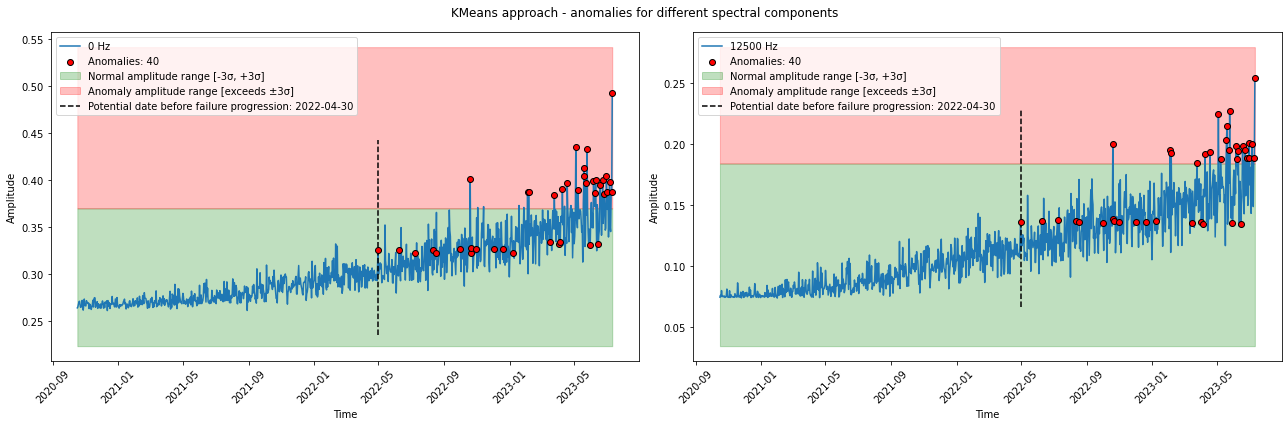

In [648]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, kmeans_date_threshold, title='KMeans', limit=True)

### KMeans Conclusions
The KMeans algorithm results in the potential date, that is very close to the date which corresponds to the median amplitude value.
Depending on different number of clusters, the resulting date remains constant.

I would say, the the KMeans approach predicts a very safe date, before the concentration of anomalies increases, and prediction for so early timestamp is caused by multiple errors. 

## DBSCAN
DBSCAN is an alternative to KMeans clustering algorithm, that groups similiar points together and treats any diverse points as outliers. Unlike in K-means, the number of clusters does not need to be specified in advance as a model hyperparameter.

In [649]:
dbscan = DBSCAN(
    eps = outliers_fraction, 
    metric='euclidean', 
    min_samples=X.shape[1] * X.shape[0] * outliers_fraction / n_clusters)

anomalies = X.copy()
anomalies['Anomaly'] = dbscan.fit_predict(X_scaled)

anomalies['Anomaly'].value_counts()

 0    925
-1     55
 1     19
Name: Anomaly, dtype: int64

In [650]:
anomalies = anomalies.loc[anomalies['Anomaly'] == -1].drop(columns='Anomaly', inplace=False)

dbscan_date_threshold = anomalies.index[0] # first date that is labeled as anomaly
print('Potential date before defect development:', dbscan_date_threshold)

Potential date before defect development: 2022-08-17 10:51:26


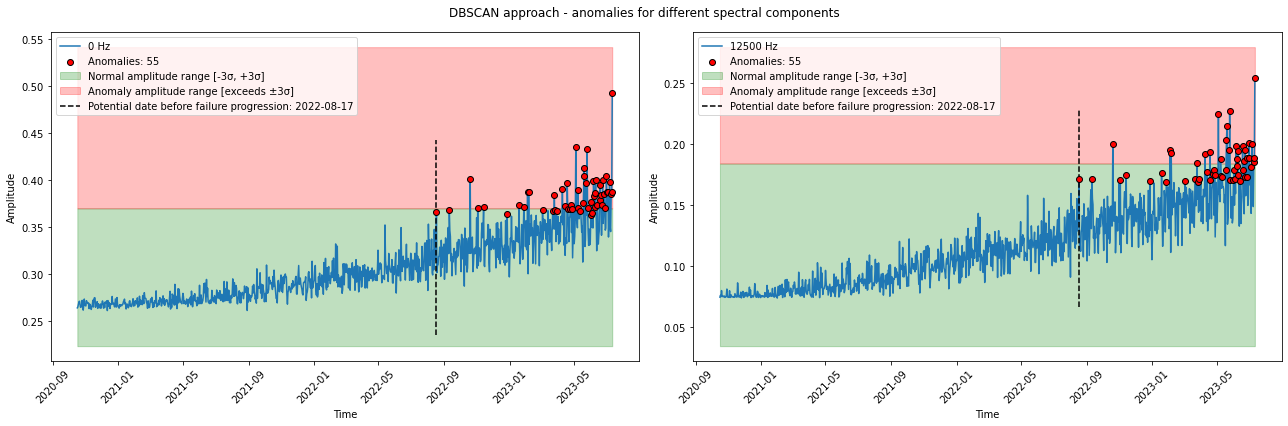

In [651]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, dbscan_date_threshold, title='DBSCAN', limit=True)

### DBSCAN - Conclusions
Similiar to KMeans, the approach using DBSCAN predicts a safe date, before the concentration of anomalies increases. Predicted timestamp is earlier than the one using the statistical approach, however occurs later than the date related to the median amplitude.

## Local Outlier Factor
**Warning Novelty detection with Local Outlier Factor (involves One Class SVM as well!)**
> When novelty is set to True be aware that you must only use **predict**, **decision_function** and **score_samples on new unseen data and not on the training samples** as this would lead to wrong results. The scores of abnormality of the training samples are always accessible through the negative_outlier_factor_ attribute.

In [652]:
lof = LocalOutlierFactor(
    n_neighbors=int(outliers_fraction * X.shape[0] * X.shape[1]),# X_scaled.shape[0] * X_scaled.shape[1], 
    algorithm='kd_tree', 
    metric='euclidean', 
    contamination=outliers_fraction,
    novelty=False)

anomalies = X.copy()
anomalies['Anomaly'] = lof.fit_predict(X_scaled)

anomalies['Anomaly'].value_counts()

 1    958
-1     41
Name: Anomaly, dtype: int64

In [653]:
# extract negative outputs as the outliers
anomalies = anomalies.loc[anomalies['Anomaly'] == -1].drop(columns='Anomaly', inplace=False)
lof_date_threshold = anomalies.index[0]

print('Potential date before defect development:', lof_date_threshold)

Potential date before defect development: 2022-09-10 10:51:26


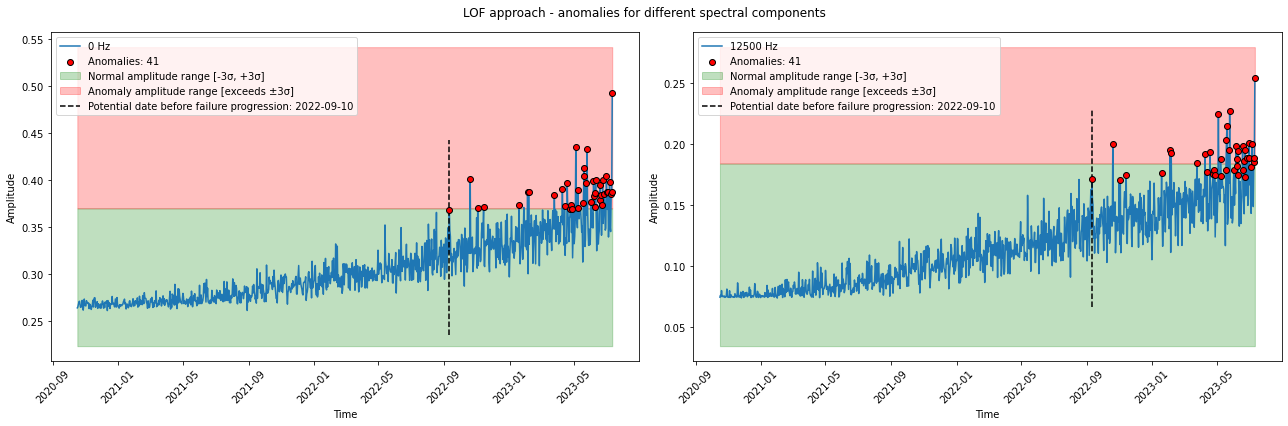

In [654]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, lof_date_threshold, title='LOF', limit=True)

### LOF - Conclusions
Results from Local Outlier Fraction are very similiar to the ones obtained using the statistical approach. Definitely there are less errors than in case of KMeans algorithm, and there is visible trend of increasing anomaly density as the time passes.
The disadventage of this method is using pretty high number of n_neighbors, which is much larger than the standard ones.

## One Class SVM
A One-class classification method is used to detect the outliers and anomalies in a dataset. Based on Support Vector Machines (SVM) evaluation, the One-class SVM applies a One-class classification method for novelty detection.

In [655]:
# train one class SVM - no anomalies in the train set
date_idx = np.where(X.index == statistical_date_threshold)[0][0]
split_idx = date_idx / len(X_scaled) # dataset potentially not containing any anomalies

X_train_scaled = X_scaled[:date_idx]
X_test_scaled = X_scaled[date_idx:]

# 10% of normal data * fraction of anomalies, it describes the sensitivity of the support vectors and is tuned to approximate ratio of outliers in data
outlier_prop = split_idx * outliers_fraction * 0.1

oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=split_idx * outliers_fraction * 0.1)
oc_svm.fit(X_train_scaled)

anomalies = X[date_idx:].copy()
anomalies['Anomaly'] = oc_svm.predict(X_test_scaled) # 1: Normal, -1: Anomaly

anomalies['Anomaly'].value_counts()

 1    221
-1     45
Name: Anomaly, dtype: int64

In [656]:
anomalies = anomalies.loc[anomalies['Anomaly'] == -1].drop(columns='Anomaly', inplace=False)
svm_date_threshold = anomalies.index[0] # first date that is labeled as anomaly

print('Potential date before defect development:', svm_date_threshold)

Potential date before defect development: 2022-10-19 10:51:26


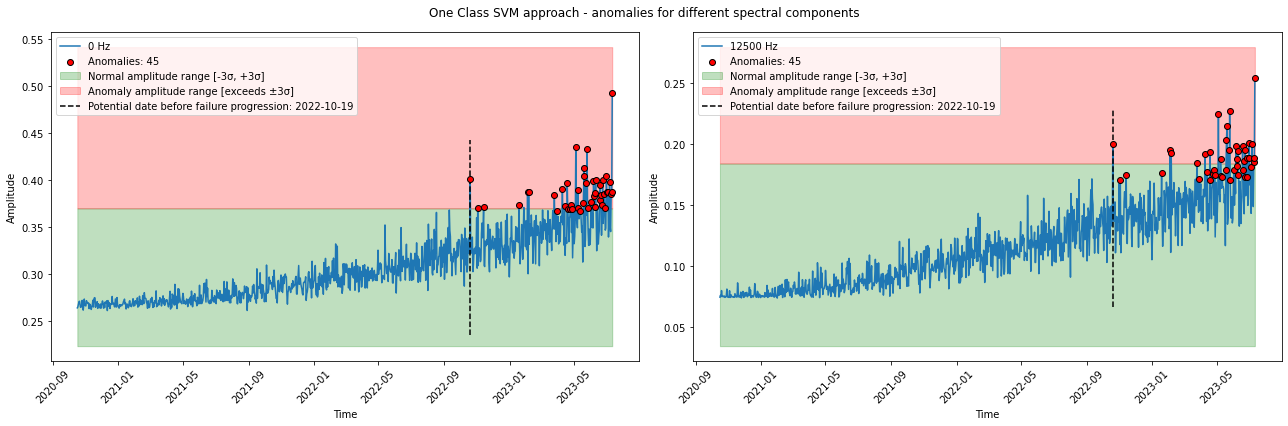

In [657]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, svm_date_threshold, title='One Class SVM', limit=True)

### OneClass SVM - Conclusions
Results from One-Class SVM are very similiar to the ones obtained using the statistical approach. Definitely there are less errors than in case of KMeans algorithm, and there is visible trend of increasing anomaly density as the time passes. It generalizes well even with standard values of hyperparameters, similiar to Isolation Forest.

## Isolation Forest

In [658]:
iso_forest = IsolationForest(n_estimators=100, bootstrap=False, contamination=outliers_fraction)
iso_forest.fit(X_scaled)

anomalies = X.copy()
anomalies['Anomaly'] = iso_forest.predict(X_scaled) # 1: Normal, -1: Anomaly

anomalies['Anomaly'].value_counts()

 1    958
-1     41
Name: Anomaly, dtype: int64

In [659]:
anomalies = anomalies.loc[anomalies['Anomaly'] == -1].drop(columns='Anomaly', inplace=False)
iso_date_threshold = anomalies.index[0] # first date that is labeled as anomaly

print('Potential date before defect development:', iso_date_threshold)

Potential date before defect development: 2022-09-10 10:51:26


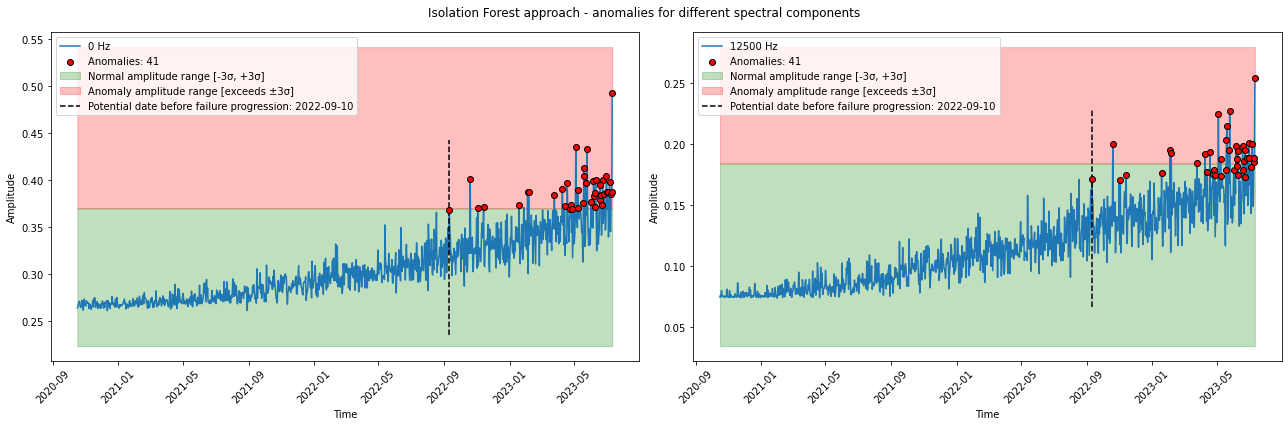

In [660]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, iso_date_threshold, title='Isolation Forest', limit=True)

### Isolation Forest - Conclusions
Results from isolation forest are very similiar to the ones obtained using the statistical approach. Definitely there are less errors than in case of KMeans algorithm, and there is visible trend of increasing anomaly density as the time passes. Even the simplest isolation forest with n_estimators=25 produces very good results.

# LSTM (Autoencoder Reconstruction Neural Network)
Great to use for sequential anomalies
RNN learns a specific pattern to recognize sequence in the data, in order to make predictions based on past experience with data. Amplitude can be labeled as anomaly, if it is different from RNN's prediction. Proper anomaly detection depends on aggregation, size of sequence and size of prediction.

By learning on previous datapoints, RNN can make prediction for the next point - any fault from trend is treated as an anomaly.

## Prepare the Training and Testing datasets

In [661]:
scaler = MinMaxScaler() # The StandardScaler should be used with normally distributed data only and RobustScaler is not senstive to outliers

train = X.loc[:statistical_date_threshold][:-1] # loc takes values at both range limits inclusively. Explicitly avoid sample classified as first anomaly occurence.
test = X.loc[statistical_date_threshold:]

X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [662]:
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [663]:
# reshape inputs for LSTM [number of samples, timesteps=1, number of features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)

X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (733, 1, 6)
Test data shape: (266, 1, 6)


In [664]:
# define the autoencoder network model
def autoencoder_model(X):
    
    input_layer = Input(
        shape=(X.shape[1], X.shape[2])
    )
    
    layer_1 = LSTM(
        16, 
        activation='relu', 
        return_sequences=True, 
        kernel_regularizer=regularizers.l2(l2=1e-5))(input_layer)
    
    layer_2 = LSTM(
        4, 
        activation='relu', 
        return_sequences=False)(layer_1)
    
    layer_3 = RepeatVector(
        X.shape[1])(layer_2)
    
    layer_4 = LSTM(
        4, 
        activation='relu', 
        return_sequences=True)(layer_3)
    
    layer_5 = LSTM(
        16, 
        activation='relu', 
        return_sequences=True)(layer_4)
    
    output_layer = TimeDistributed(
        Dense(X.shape[2]))(layer_5)    

    return Model(
        inputs=input_layer, 
        outputs=output_layer)

In [665]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), 
    loss='mae')
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1472      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 6)             

In [666]:
# fit the model to the data
n_epochs = 100
batch_size = 10
history = model.fit(
    X_train, # Please note that we are using x_train as both the input and the target since this is a reconstruction model.
    X_train, 
    epochs=n_epochs, 
    batch_size=batch_size,
    validation_split=outliers_fraction).history

Epoch 1/100
71/71 [==============================] - 2s 21ms/step - loss: 0.2196 - val_loss: 0.5312
Epoch 2/100
71/71 [==============================] - 1s 16ms/step - loss: 0.1816 - val_loss: 0.4459
Epoch 3/100
71/71 [==============================] - 1s 15ms/step - loss: 0.1357 - val_loss: 0.1631
Epoch 4/100
71/71 [==============================] - 1s 15ms/step - loss: 0.0930 - val_loss: 0.1266
Epoch 5/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0762 - val_loss: 0.1248
Epoch 6/100
71/71 [==============================] - 1s 15ms/step - loss: 0.0629 - val_loss: 0.1361
Epoch 7/100
71/71 [==============================] - 1s 15ms/step - loss: 0.0496 - val_loss: 0.0666
Epoch 8/100
71/71 [==============================] - 1s 14ms/step - loss: 0.0359 - val_loss: 0.0546
Epoch 9/100
71/71 [==============================] - 1s 15ms/step - loss: 0.0247 - val_loss: 0.0342
Epoch 10/100
71/71 [==============================] - 1s 15ms/step - loss: 0.0186 - val_loss: 0.0226

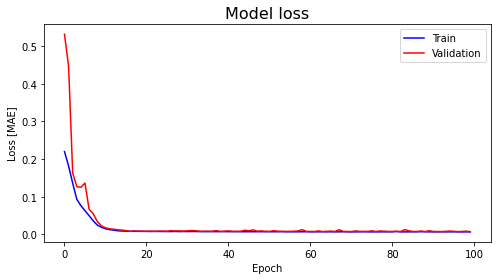

In [667]:
# plot the Train and Validation loss for the Model
plt.figure(figsize=(8, 4))
plt.plot(history['loss'], 'b', label='Train')
plt.plot(history['val_loss'], 'r', label='Validation')
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch'), plt.ylabel('Loss [MAE]')
plt.legend()
plt.show()

## Detecting anomalies
The anomalies are detected based on how well the model can reconstruct the input data

    1. Find MAE loss on training samples
    2. Find max MAE loss value. This is the worst the model has performed tryging to reconstruct a sample.
    3. If a reconstruction loss for a sample is greater than the threshold, then ew can assume that this sample is an anomaly

In [668]:
# calculate the loss on the train set
X_train_pred = model.predict(X_train) # predict on train data

X_train_pred = pd.DataFrame(
    data=X_train_pred.reshape(X_train_pred.shape[0], X_train_pred.shape[2]), # reshape predictions to match DataFrame format, 
    columns=train.columns, 
    index=train.index)

X_train_scored = pd.DataFrame(
    data=np.mean(
        np.abs(X_train_pred - X_train.reshape(X_train.shape[0], X_train.shape[2])), # reshape train set to match predictions format
        axis=1),
    columns=['Loss_MAE'],
    index=train.index)

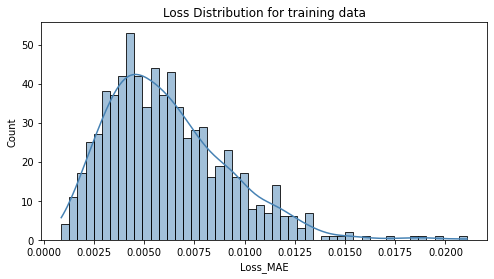

In [669]:
# plot the loss distribution of the training set
plt.figure(figsize=(8, 4))
plt.title('Loss Distribution for training data')
sns.histplot(X_train_scored['Loss_MAE'], bins=50, kde=True, color='steelblue');
# plt.xlim([0.0,.03])
plt.show()

In [670]:
loss_threshold = X_train_scored['Loss_MAE'].max()
print('Reconstruction error threshold: {:.5f}'.format(loss_threshold))

Reconstruction error threshold: 0.02108


In [671]:
# calculate the loss on the test set
X_test_pred = model.predict(X_test) # predict on test data

X_test_pred = pd.DataFrame(
    data=X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2]), # reshape predictions to match DataFrame format
    columns=test.columns, 
    index=test.index)

X_test_scored = pd.DataFrame(
    data=np.mean(
        np.abs(X_test_pred - X_test.reshape(X_test.shape[0], X_test.shape[2])), # reshape train set to match predictions format
        axis=1),
    columns=['Loss_MAE'],
    index=test.index)

X_test_scored['Anomaly'] = X_test_scored['Loss_MAE'] > loss_threshold
X_test_scored.head()

,Loss_MAE,Anomaly
2022-10-19 10:51:26,0.075828,True
2022-10-20 10:51:26,0.012638,False
2022-10-21 10:51:26,0.006943,False
2022-10-22 10:51:26,0.006768,False
2022-10-23 10:51:26,0.013384,False


In [672]:
# add Threshold and Anomaly column to X_train_scored
X_train_scored['Anomaly'] = X_train_scored['Loss_MAE'] > loss_threshold

X_train_scored.head()

,Loss_MAE,Anomaly
2020-10-16 10:51:26,0.004284,False
2020-10-17 10:51:26,0.007041,False
2020-10-18 10:51:26,0.003438,False
2020-10-19 10:51:26,0.001984,False
2020-10-20 10:51:26,0.011044,False


In [673]:
print(f"Number of anomalies in the train set (before {statistical_date_threshold.strftime('%Y-%m-%d')}):", np.sum(X_train_scored['Anomaly'] == True))
print(f"Number of anomalies in the test set (after {statistical_date_threshold.strftime('%Y-%m-%d')}):", np.sum(X_test_scored['Anomaly'] == True))

Number of anomalies in the train set (before 2022-10-19): 0
Number of anomalies in the test set (after 2022-10-19): 50


In [674]:
anomalies = pd.concat(
    [X, pd.concat([X_train_scored, X_test_scored], axis=0)],
    axis=1
)

anomalies['Anomaly'].value_counts()

False    949
True      50
Name: Anomaly, dtype: int64

In [675]:
anomalies = anomalies.loc[anomalies['Anomaly'] == True].drop(columns=['Loss_MAE', 'Anomaly'], inplace=False)
lstm_date_threshold = anomalies.index[0] # first date that is labeled as anomaly

print('Potential date before defect development:', lstm_date_threshold)

Potential date before defect development: 2022-10-19 10:51:26


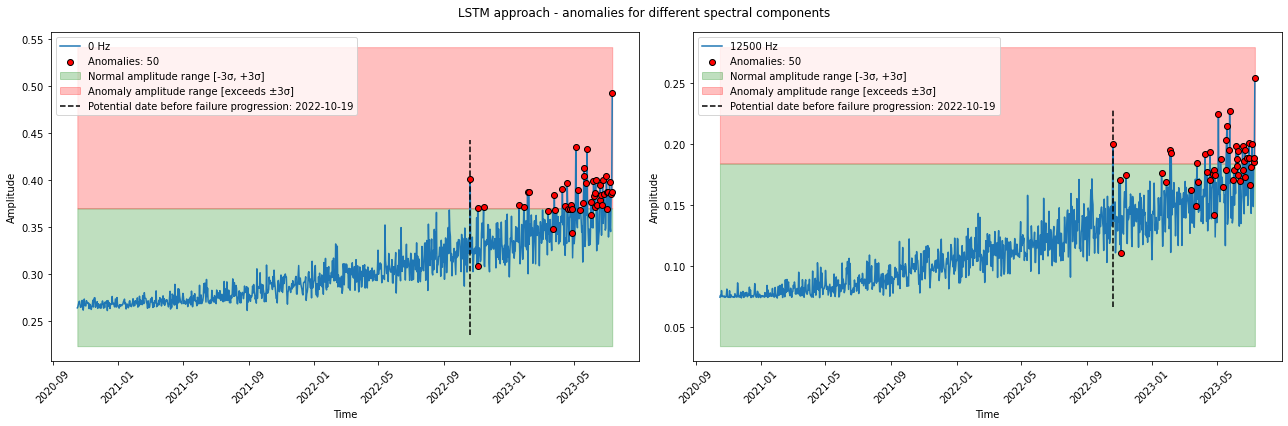

In [676]:
plot_anomalies(X, anomalies, lower_bound_6f, upper_bound_6f, lstm_date_threshold, title='LSTM', limit=True)

### LSTM - Conclusion
Long Short Term Memory RNN performs pretty well on the data, since it also detects anomalies in the form of amplitude drops, while most of the algorithms were focusing on the upper bound as the threshold.

## Multivariate Unsupervised Learning - Conclusion
In my opinion, the best performing model is the LSTM and Isolation Forest. With their use I am able to detect failure development beginning on the same day as with the statistical approach, which is based on Median Absolute Deviation. 
The LSTM detects also the anomalous amplitude drops and this may be a key in forecasting any kind of system failure within the time.
KMeans performs the worst - it is very random and does not generalize well. The Local Outlier Fraction and DBSCAN clustering algorithms detect the outliers with higher accuracy. The One Class SVM on the other hand is a compromise between earlier potential date and low complexity of the algorithm - similiar to Isolation Forest it gives pretty decent results without any hyperparameter tuning. The tricky part of this algorithm is the dependence on the Statistical Aproach, since the dataset has to be divided in training and testing set, where the training set must not contain any anomaly samples, and test set should contain anomaly samples in order detect the diverse magnitude changes.

Median date at which the system's failure development may begin:


In [694]:
all_dates = [
    median_date_threshold, 
    statistical_date_threshold, 
    kmeans_date_threshold, 
    dbscan_date_threshold,
    lof_date_threshold, 
    svm_date_threshold, 
    lstm_date_threshold
]

all_dates_threshold = pd.Series(all_dates).astype('datetime64[ns]').quantile(0.5)
print('Potential date before failure development, taking into account all dates:', all_dates_threshold)

all_dates_threshold_unique = pd.Series(np.unique(all_dates)).astype('datetime64[ns]').quantile(0.5)
print('Potential date before failure development, taking into account only unique dates:', all_dates_threshold_unique)

Potential date before failure development, taking into account all dates: 2022-09-10 10:51:26
Potential date before failure development, taking into account only unique dates: 2022-08-17 10:51:26
